In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tqdm import tqdm

from metrics import accuracy
from utils import (
    _fix_seeds,
    plot_metric_history,
    plot_repeated_exp_metrics,
    show_images
)
from models_classes import (
    BNModel1,
    BNModel2
)

In [2]:
# load data
mnist = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist
X_train, X_test = X_train / 255.0, X_test / 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X_train = tf.cast(X_train.reshape(-1, 784), tf.float32)
y_train = tf.cast(tf.one_hot(y_train, 10), tf.float32)

X_test = tf.cast(X_test.reshape(-1, 784), tf.float32)
y_test = tf.cast(tf.one_hot(y_test, 10), tf.float32)   

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [50]:
# define train proces
def train(model, X, y, optimizer):
    """
    One step of train process
    
    params:
        model: model object to train
        X: data
        y: target 
        optimizer: tf optimizer
    return:
        loss_val: loss value
    """
    with tf.GradientTape() as t:
        y_pred_logit = model(X)
        loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_pred_logit))
        
    grads = t.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    acc = accuracy(y, tf.nn.softmax(y_pred_logit))
    
    return loss_val, acc


# define evaluate proces
def evaluate(model, X, y):
    """
    One step of evaluation process
    
    params:
        model: model object to evaluate
        X: data to evaluate
        y: target 
    return:
        loss_val: loss value
    """
    y_pred_logit = model(X)
    loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_pred_logit))
    
    acc = accuracy(y, tf.nn.softmax(y_pred_logit))
    
    return loss_val, acc


def one_experiment(X_train, y_train, X_test, y_test, \
                   model, optimizer, 
                   num_steps=1000, batch_size=128):
    """
    Run one experiment.
    
    returns:
        loss_history: dict of lists
        acc_history: dict of lists
    """
    # collect metrics
    loss_history = {
        'train': [],
        'test': []
    }
    acc_history = {
        'train': [],
        'test': []
    }

    # running optimization
    for i in range(num_steps):

        # select train data batch
        indices = np.random.choice(len(X_train), batch_size)
        X_train_batch, y_train_batch = tf.gather(X_train, indices, axis=0), tf.gather(y_train, indices, axis=0)

        # train model
        train_loss, train_acc = train(model, X_train_batch, y_train_batch, optimizer)

        # select test data batch
        indices = np.random.choice(len(X_test), batch_size)
        X_test_batch, y_test_batch = tf.gather(X_test, indices, axis=0), tf.gather(y_test, indices, axis=0)  

        # evaluate model
        test_loss, test_acc = evaluate(model, X_test_batch, y_test_batch)

        # collect current metrics
        loss_history['train'].append(train_loss.numpy())
        loss_history['test'].append(test_loss.numpy())
        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        
        
        
    return loss_history, acc_history

def get_plain_loss(loss_history_exp, acc_history_exp):
    
    loss_plain_mtrx = {
    'train':[],
    'test':[]
    }
    acc_plain_mtrx = {
        'train':[],
        'test':[]    
    }

    for exp_loss, exp_acc in zip(loss_history_exp, acc_history_exp):
        loss_plain_mtrx['train'].append(exp_loss['train'])
        loss_plain_mtrx['test'].append(exp_loss['test'])

        acc_plain_mtrx['train'].append(exp_acc['train'])
        acc_plain_mtrx['test'].append(exp_acc['test']) 

    loss_plain_mtrx['train'] = np.array(loss_plain_mtrx['train'])
    loss_plain_mtrx['test'] = np.array(loss_plain_mtrx['test'])

    acc_plain_mtrx['train'] = np.array(acc_plain_mtrx['train'])
    acc_plain_mtrx['test'] = np.array(acc_plain_mtrx['test'])
    
    return loss_plain_mtrx, acc_plain_mtrx


In [69]:
def process(sentences):
    #YOUR CODE
    stroka=[]
    for sen in sentences:     
        stroka.append(' '.join([x for x in sen.split() if x.isalpha()]))
    
    return stroka


In [68]:
process(['1 thousand devils', 'My name is 9Pasha', 'Room #125 costs $100', '888'])


['thousand devils', 'My name is', 'Room costs', '']

## BN

In [51]:
%%time
# set constants
_fix_seeds(42)

lr = 1e-2
wd = 1e-5
batch_size = 128
num_steps = 200
repeat_num = 100

loss_history_exp = []
acc_history_exp = []

for j in tqdm(range(repeat_num)):
    
    # Set up model and optimier
    model1 = BNModel1()
    optimizer = tf.optimizers.Adam(learning_rate=lr, decay=wd)

    loss_history, acc_history = one_experiment(X_train, y_train, X_test, y_test, \
                                               model1, optimizer, 
                                               num_steps=num_steps,
                                               batch_size=batch_size)
        
    loss_history_exp.append(loss_history)
    acc_history_exp.append(acc_history)
   

100%|██████████| 100/100 [04:11<00:00,  2.52s/it]

CPU times: user 10min 25s, sys: 17.9 s, total: 10min 43s
Wall time: 4min 11s


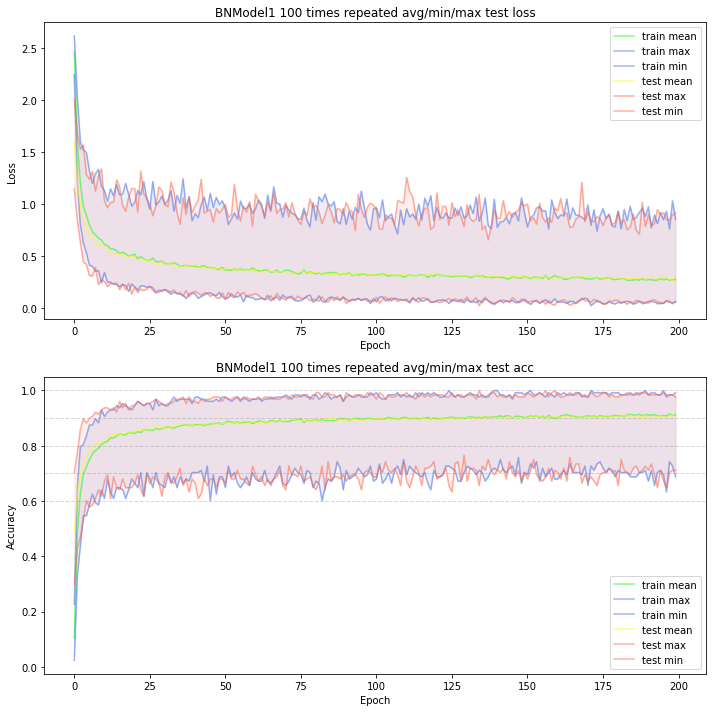

In [18]:
loss_plain_mtrx, acc_plain_mtrx = get_plain_loss(loss_history_exp, acc_history_exp)
plot_repeated_exp_metrics(loss_plain_mtrx, acc_plain_mtrx, repeat_num, num_steps, model_name=model1.__name__)

## Without BN

In [19]:
%%time
# set constants
_fix_seeds(42)

lr = 1e-2
batch_size = 128
num_steps = 200
repeat_num = 100

loss_history_exp = []
acc_history_exp = []

for j in tqdm(range(repeat_num)):
    
    # Set up model and optimier
    model2 = BNModel2()
    optimizer = tf.optimizers.Adam(learning_rate=lr)

    loss_history, acc_history = one_experiment(X_train, y_train, X_test, y_test, \
                                               model2, optimizer, 
                                               num_steps=num_steps,
                                               batch_size=batch_size)
        
    loss_history_exp.append(loss_history)
    acc_history_exp.append(acc_history)

  1%|          | 1/100 [00:03<05:24,  3.28s/it]


KeyboardInterrupt: 

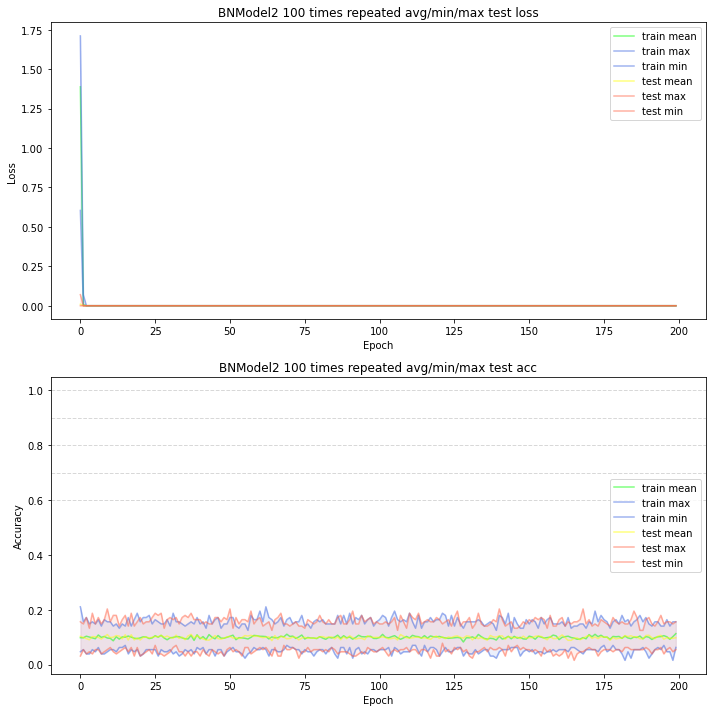

In [15]:
loss_plain_mtrx, acc_plain_mtrx = get_plain_loss(loss_history_exp, acc_history_exp)
plot_repeated_exp_metrics(loss_plain_mtrx, acc_plain_mtrx, repeat_num, num_steps, model_name=model2.__name__)